# CS 565 Analysis - StackOverflow Newcomers
[View the notebook on nbviewer instead.](https://nbviewer.org/github/jackiec1998/cs565-final-project/blob/main/newcomers.ipynb?flush_cache=false)

In [54]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data Ingestion

In [55]:
newcomers = pd.read_csv('newcomers.csv', parse_dates=['FirstPostDate', 'AccountCreationDate'])
year = pd.read_csv('numPostsWithinYear.csv')
two_posts = pd.read_csv('timeBetweenFirstTwo.csv', parse_dates=['FirstPostDate', 'SecondPostDate'])

## Data Preprocessing

In [56]:
def normalize(column, df):
    return df[column] / df['NumInitialPosts']

newcomers['Lurking'] = (newcomers['FirstPostDate'] - newcomers['AccountCreationDate']).dt.days

newcomers['AvgUpVotes'] = normalize('TotalUpVotes', newcomers)
newcomers['AvgDownVotes'] = normalize('TotalDownVotes', newcomers)
newcomers['AvgAcceptances'] = normalize('TotalAnswersAccepted', newcomers)
newcomers['AvgBookmarks'] = normalize('TotalBookmarked', newcomers)
newcomers['AvgClosed'] = normalize('TotalClosed', newcomers)
newcomers['AvgDeleted'] = normalize('TotalDeleted', newcomers)
newcomers['AvgSpam'] = normalize('TotalMarkedAsSpam', newcomers)

newcomers['AvgNumEdits'] = normalize('TotalSuggestedEdits', newcomers)
newcomers['NumAnswers'] = newcomers['NumInitialPosts'] - newcomers['NumQuestions']

newcomers['Retained'] = (newcomers['NumFuturePosts'] > 0).astype(int)

In [57]:
newcomers.dtypes.to_frame().rename(columns={0: 'Type'})

,Type
UserId,int64
AccountCreationDate,datetime64[ns]
FirstPostDate,datetime64[ns]
NumInitialPosts,int64
NumQuestions,int64
AvgViewCount,float64
AvgNumAnswers,float64
AvgTopAnswererRep,float64
AvgTopAnswererAge,float64
TotalSuggestedEdits,int64


## Number of Posts Stack Overflow Users Make During Their First Year

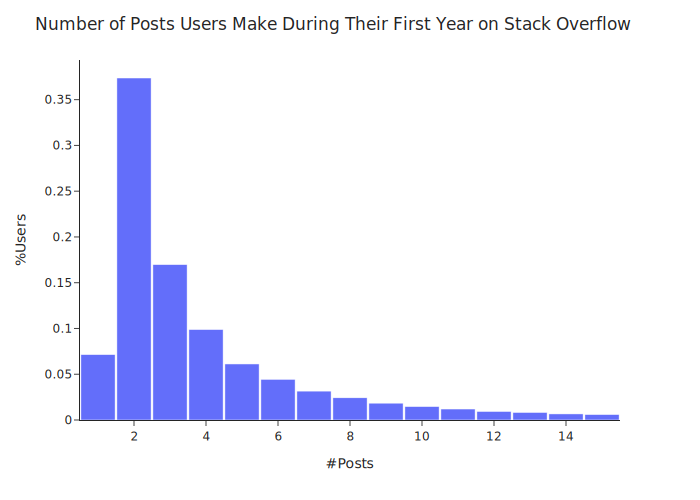

In [53]:
X_MAX_RANGE = 15

fig = px.bar(year['NumPosts'].value_counts().sort_index() / len(year))

fig.update_xaxes(
    range=[0.5, X_MAX_RANGE + 0.5],
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    template='simple_white',
    bargap=0.05,
    showlegend=False,
    title='Number of Posts Users Make During Their First Year on Stack Overflow',
    xaxis_title='#Posts',
    yaxis_title='%Users',
    font_family='Calibri'
)

fig.show('svg')
fig.write_image('figs/num-posts-year.png', scale=3)

## Distribution of Newcomer's Initial Posts and Future Posts

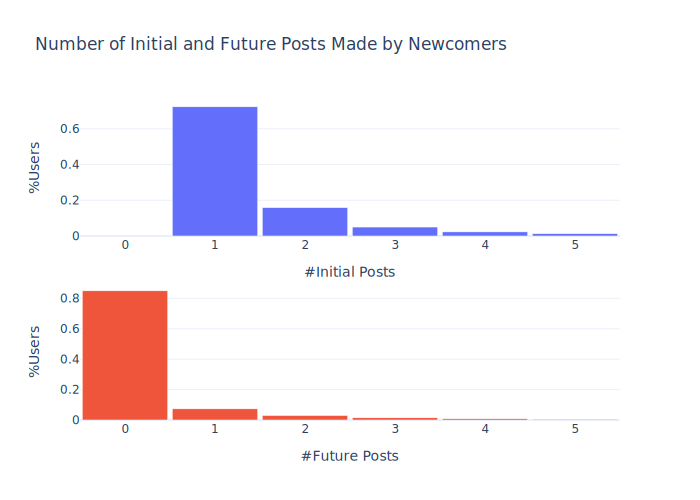

In [104]:
X_MAX_RANGE = 5

fig = make_subplots(rows=2, cols=1)

# Initial Posts
initial_dist = newcomers['NumInitialPosts'].value_counts().sort_index() / len(newcomers)

fig.add_trace(
    go.Bar(x=initial_dist.index, y=initial_dist.values),
    row=1, col=1
)

fig.update_xaxes(
    title_text='#Initial Posts',
    row=1, col=1
)

fig.update_yaxes(
    title_text='%Users',
    row=1, col=1
)

# Future Posts
future_dist = newcomers['NumFuturePosts'].value_counts().sort_index() / len(newcomers)

fig.add_trace(
    go.Bar(x=future_dist.index, y=future_dist.values),
    row=2, col=1
)

fig.update_xaxes(
    title_text='#Future Posts',
    row=2, col=1
)

fig.update_yaxes(
    title_text='%Users',
    row=2, col=1
)

fig.update_xaxes(
    range=[-0.5, X_MAX_RANGE + 0.5]
)

fig.update_layout(
    template='plotly_white',
    bargap=0.05,
    showlegend=False,
    title='Number of Initial and Future Posts Made by Newcomers',
    font_family='Calibri'
)

fig.show('svg')
fig.write_image('figs/num-initial-future.png', scale=3)

## Whether Newcomers Experience Particular Features

In [109]:
properties = [
    ('TotalSuggestedEdits', 'Edited Post'),
    ('TotalClosed', 'Closed Question'),
    ('TotalAnswersAccepted', 'Accepted Answer'),
    ('TotalBookmarked', 'Bookmarked Post'),
    ('TotalDeleted', 'Deleted Post'),
    ('TotalMarkedAsSpam', 'Spam Post')
]

table = {}

for property, name in properties:
    table[name] = {
        '%Experienced': len(newcomers[newcomers[property] > 0]) / len(newcomers),
        '#Experienced': len(newcomers[newcomers[property] > 0]),
        '%Did Not Experience': len(newcomers[newcomers[property] == 0]) / len(newcomers),
        '#Did Not Experience': len(newcomers[newcomers[property] == 0])
    }

pd.DataFrame.from_dict(table, orient='index')

,%Experienced,#Experienced,%Did Not Experience,#Did Not Experience
Edited Post,0.185347,32111,0.814653,141137
Closed Question,0.000000,0,1.000000,173248
Accepted Answer,0.073807,12787,0.926193,160461
Bookmarked Post,0.056878,9854,0.943122,163394
Deleted Post,0.006973,1208,0.993027,172040
Spam Post,0.000000,0,1.000000,173248


## Percentage of Users Retained (i.e., Posted During Retention Period)

In [134]:
properties = [
    (np.ones(len(newcomers)).astype(bool), 'All Newcomers'),
    (newcomers['TotalSuggestedEdits'] > 0, 'Newcomers with Edits'),
    (newcomers['NumQuestions'] > 0, 'Newcomers with Questions'),
    (newcomers['NumAnswers'] > 0, 'Newcomers with Answers')
]

table = {}

for filter, name in properties:
    table[name] = {
        '%Retained': (newcomers[filter]['Retained'].value_counts()[1] / len(newcomers)).round(3) * 100,
        '#Retained': newcomers[filter]['Retained'].value_counts()[1],
        '%Not Retained': (newcomers[filter]['Retained'].value_counts()[0] / len(newcomers)).round(3) * 100,
        '#Not Retained': newcomers[filter]['Retained'].value_counts()[0],
        'Total Newcomers': len(newcomers[filter])
    }

pd.DataFrame.from_dict(table, orient='index')

,%Retained,#Retained,%Not Retained,#Not Retained,Total Newcomers
All Newcomers,15.0,26015,85.0,147233,173248
Newcomers with Edits,3.0,5244,15.5,26867,32111
Newcomers with Questions,11.8,20432,63.6,110142,130574
Newcomers with Answers,5.8,9997,29.7,51451,61448


## Utility Functions

In [49]:
def log_odds(model):
    odds = model.conf_int()
    odds['Odds Ratio'] = model.params
    odds.columns = ['5%', '95%', 'Odds Ratio']
    odds = np.exp(odds)

    return odds

def retained_split(data):
    df = (data['Retained'].astype(bool).value_counts() / len(data.index)).to_frame()
    df['N'] = data['Retained'].astype(bool).value_counts()
    df = df.append({
        'Retained': df['Retained'].sum(),
        'N': df['N'].sum()
    }, ignore_index=True)

    df.index = ['True', 'False', 'Total']

    return df

## All Posts Logistic Regression

In [54]:
'''
    Logistic regression over all posts (i.e. questions and answers).
'''
model = smf.logit(
    formula='Retained ~ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ Lurking',
    data=nc
).fit(disp=False) # Turning off annoying print statement.

display(retained_split(nc))
display(model.summary())
display(log_odds(model))

,Retained,N
True,0.851341,147717.0
False,0.148659,25794.0
Total,1.000000,173511.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               173511
Model:                          Logit   Df Residuals:                   173505
Method:                           MLE   Df Model:                            5
Date:                Tue, 29 Mar 2022   Pseudo R-squ.:               0.0009023
Time:                        11:50:41   Log-Likelihood:                -72874.
converged:                       True   LL-Null:                       -72940.
Covariance Type:            nonrobust   LLR p-value:                 1.076e-26
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.7643      0.008   -209.887      0.000      -1.781      -1.748
AvgUpVotes           0.0104      0.003      3.165      0.002       0.004       0.017
AvgDownVotes        -0.0588      0.012     -5.064      0.000      -0.082      -0.036
AvgOtherPositive     0.1614      0.023      7.065      0.000       0.117       0.206
AvgOtherNegative    -0.2649      0.115     -2.313      0.021      -0.489      -0.040
Lurking           4.576e-05   1.19e-05      3.843      0.000    2.24e-05    6.91e-05
====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.168511,0.174156,0.171310
AvgUpVotes,1.003983,1.017045,1.010492
AvgDownVotes,0.921697,0.964610,0.942909
AvgOtherPositive,1.123688,1.228958,1.175145
AvgOtherNegative,0.612939,0.960410,0.767251
Lurking,1.000022,1.000069,1.000046


## Answered Questions Logistic Regression

In [55]:
data = nc[(nc['NumQuestions'] > 0) & (nc['AvgNumAnswers'] > 0)]

model = smf.logit(
    formula='Retained ~ AvgTopAnswererRep + AvgTopAnswererAge ' \
        '+ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ Lurking + AvgViewCount + AvgNumAnswers',
    data=data
).fit(disp=False)


display(retained_split(data))
display(model.summary())
display(log_odds(model))

,Retained,N
True,0.832198,85748.0
False,0.167802,17290.0
Total,1.000000,103038.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               103038
Model:                          Logit   Df Residuals:                   103028
Method:                           MLE   Df Model:                            9
Date:                Tue, 29 Mar 2022   Pseudo R-squ.:                0.002099
Time:                        11:50:44   Log-Likelihood:                -46515.
converged:                       True   LL-Null:                       -46613.
Covariance Type:            nonrobust   LLR p-value:                 2.690e-37
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5671      0.021    -74.776      0.000      -1.608      -1.526
AvgTopAnswererRep  2.736e-07   6.56e-08      4.169      0.000    1.45e-07    4.02e-07
AvgTopAnswererAge -3.687e-05   7.77e-06     -4.742      0.000   -5.21e-05   -2.16e-05
AvgUpVotes            0.0110      0.007      1.663      0.096      -0.002       0.024
AvgDownVotes         -0.1311      0.013    -10.178      0.000      -0.156      -0.106
AvgOtherPositive      0.0396      0.030      1.301      0.193      -0.020       0.099
AvgOtherNegative      0.1923      0.140      1.378      0.168      -0.081       0.466
Lurking            6.913e-05   1.68e-05      4.123      0.000    3.63e-05       0.000
AvgViewCount       1.409e-05   3.71e-06      3.795      0.000    6.81e-06    2.14e-05
AvgNumAnswers         0.0117      0.012      0.943      0.346      -0.013       0.036
=====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.200245,0.217391,0.208642
AvgTopAnswererRep,1.000000,1.000000,1.000000
AvgTopAnswererAge,0.999948,0.999978,0.999963
AvgUpVotes,0.998044,1.024214,1.011044
AvgDownVotes,0.855227,0.899530,0.877099
AvgOtherPositive,0.980137,1.104374,1.040403
AvgOtherNegative,0.921992,1.593288,1.212022
Lurking,1.000036,1.000102,1.000069
AvgViewCount,1.000007,1.000021,1.000014
AvgNumAnswers,0.987426,1.036767,1.011796


## Edited Posts Logistic Regression

In [56]:
data = nc[nc['TotalSuggestedEdits'] > 0]

model = smf.logit(
    formula='Retained ~ AvgEditorRep + AvgEditorAge ' \
        '+ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ AvgNumEdits + Lurking',
    data=data
).fit(disp=False)

display(retained_split(data))
display(model.summary())
display(log_odds(model))

# Notes: AvgOtherNegative and AvgNumEdits seem abnormally impactful towards retention.

,Retained,N
True,0.835842,26930.0
False,0.164158,5289.0
Total,1.000000,32219.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:                32219
Model:                          Logit   Df Residuals:                    32210
Method:                           MLE   Df Model:                            8
Date:                Tue, 29 Mar 2022   Pseudo R-squ.:                 0.03886
Time:                        11:50:46   Log-Likelihood:                -13827.
converged:                       True   LL-Null:                       -14386.
Covariance Type:            nonrobust   LLR p-value:                4.978e-236
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5728      0.041    -13.806      0.000      -0.654      -0.491
AvgEditorRep      7.866e-08   6.11e-06      0.013      0.990   -1.19e-05    1.21e-05
AvgEditorAge     -4.506e-05   1.61e-05     -2.803      0.005   -7.66e-05   -1.36e-05
AvgUpVotes           0.0182      0.005      3.455      0.001       0.008       0.029
AvgDownVotes        -0.0060      0.025     -0.237      0.812      -0.056       0.044
AvgOtherPositive     0.0631      0.055      1.148      0.251      -0.045       0.171
AvgOtherNegative    -0.5023      0.299     -1.677      0.093      -1.089       0.085
AvgNumEdits         -1.3575      0.043    -31.504      0.000      -1.442      -1.273
Lurking           9.647e-05   3.07e-05      3.137      0.002    3.62e-05       0.000
====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.519913,0.611731,0.563957
AvgEditorRep,0.999988,1.000012,1.000000
AvgEditorAge,0.999923,0.999986,0.999955
AvgUpVotes,1.007916,1.028970,1.018388
AvgDownVotes,0.945776,1.044677,0.993997
AvgOtherPositive,0.956309,1.186456,1.065185
AvgOtherNegative,0.336491,1.088309,0.605150
AvgNumEdits,0.236478,0.279990,0.257316
Lurking,1.000036,1.000157,1.000096
